## Animal Faces using Conditional GAN

In this project we will be implementing Conditional GAN, which can generate images based on the class requirement. The dataset we are going to use is from Kaggle(<cite>https://www.kaggle.com/andrewmvd/animal-faces</cite>) and it consists of Animal Faces namely Dog, Cat, and Wild.

Lets get started by importing the necessary packages.

**Disclaimer** : Please dont be overwhelmed by all the imports. I love to import all the necessary packages in the first cell, and whenever I need something I come back and write the imports and rerun the first cell.

In [1]:
## Importing the necessary Packages ##

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt

Now with the packages imported, lets get going by importing our dataset.

We are going to utilize the same structural orientation as our previous W-Gan model. So, lets get our hands dirty.

We will import the dataset for sure, but first we need some transformations to go with it.
1. Resize to (64 , 64 , 3)
2. Make them tensor by ToTensor
3. Normalize them to make the images range between [-1,1]

In [2]:
## Setting the Transforms ##

trans = transforms.Compose([
    transforms.Resize((64 , 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, ) , (0.5 ,))
])

Now we are ready. Lets import the dataset.

In [3]:
## Importing the Dataset ##

animal_data = ImageFolder(root = 'train',
                          transform = trans)

And done.

Lets check the data.

In [4]:
## Testing the loaded dataset ##

print('Dataset Length :' , len(animal_data))
print('Image Shape :' , animal_data[0][0].shape)
print('Label :' , animal_data[0][1])

Dataset Length : 14630
Image Shape : torch.Size([3, 64, 64])
Label : 0


Cool.

Thats what we wanted.

Now we should also visulize a sample of data. But since, we are going to implement through Matplotlib, it expect the data to have the channels at the end. Furthermore, it also requires the data to be in range between [0,1]. Hence, we need to denormalize as well as put our channels at the end to garnish the images.

In [5]:
## Denormalize Images ##

def denorm_img(img):
    return img * 0.5 + 0.5

Now lets display an image.

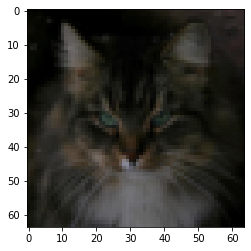

In [6]:
## Display an image ##

plt.imshow(denorm_img(animal_data[0][0]).permute(1 , 2 , 0))
plt.show()

Ahh nice! A cat is here!

Lets move on.

So, next up we are going to create our own dataloader which are going to feed in data to our model.

So, lets do that.

In [7]:
## Forming Dataloader ##

animal_dataloader = DataLoader(dataset = animal_data,
                               batch_size = 16,
                               shuffle = True)

Now lets visualize some of the data from dataloader.

For this we are going to make use of the make_grid method from torchvision.utils.

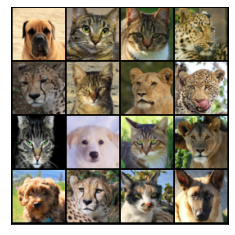

In [8]:
## Visaulizing a batch of data ##

for img , labels in animal_dataloader:
    figure , ax = plt.subplots(figsize = (4 , 4))
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(make_grid(denorm_img(img) , 4).permute(1 , 2 , 0))
    plt.show()
    break

And cool! We can clearly visualize the images.

Now pytorch doesn't automatically use Parallel Computing using CUDA even if you have a GPU with Cuda installed.

So, lets build our custom class of dataloader which feeds data to the GPU for the models to take as inputs.

But, before that we need to formulate some utility functions to check for CUDA and also transfer data.

In [9]:
## Check for cuda availablity ##

def cuda_avail():
    if torch.cuda.is_available():
        return torch.device('cuda')
    return torch.device('cpu')

## Transfer data to specified device ##

def transfer_data(data , device):
    if isinstance(data , (list , tuple)):
        return [transfer_data(each_data , device) for each_data in data]
    return data.to(device)

## Defining the GPU Dataloader ##

class gpu_dl():
    def __init__(self , dl , device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for batch in self.dl:
            yield transfer_data(batch , self.device)
    
    def __len__(self):
        return len(self.dl)

Now lets set our gpu dataloader.

In [10]:
## Fetching device ##

device = cuda_avail()

## Setting dl as GPU Dataloader ##

animal_dl = gpu_dl(animal_dataloader , device)

Lets check our dataloader and visualize a batch of data.

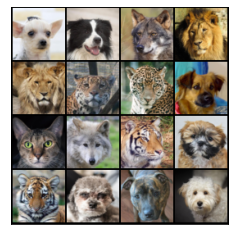

In [11]:
## Visualizing a batch of images ##

for img , labels in animal_dl:
    figure , ax = plt.subplots(figsize = (4 , 4))
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(make_grid(denorm_img(img).to('cpu') , 4).permute(1 , 2 , 0))
    break

Boom its done!

In a bit later portion we will implement a visualization utility function which would be used during training.

But, before that lets define our Discriminator and Generator.

Since we are using the same structure as the WGAN model, it wont be much different from our previous notebook.

So, lets carry on.

In [12]:
## Defining Generator Module ##

class Generator(nn.Module):
    def __init__(self , in_dim , out_dim , hidden_dim):
        super().__init__()
        self.gen_model = nn.Sequential(
        self.gen_block(in_dim , hidden_dim * 64 , 4 , 1 , 0), ##(4 , 4 , 1024)
        self.gen_block(hidden_dim * 64 , hidden_dim * 32 , 4 , 2 , 1), ## (8 , 8 , 512)
        self.gen_block(hidden_dim * 32 , hidden_dim * 16 , 4 , 2 , 1), ## (16 , 16 , 256)
        self.gen_block(hidden_dim * 16 , hidden_dim * 8 , 4 , 2 , 1), ## (32 , 32 , 128)    
        nn.ConvTranspose2d(in_channels = hidden_dim * 8 , 
                           out_channels = out_dim , 
                           kernel_size = 4 , 
                           stride = 2,
                           padding = 1) , 
        nn.BatchNorm2d(out_dim),
        nn.Tanh()
        )
    
    def gen_block(self , input_dim , output_dim , filter_size , stride , padding):
        return nn.Sequential(nn.ConvTranspose2d(in_channels = input_dim , 
                                                out_channels = output_dim , 
                                                kernel_size = filter_size , 
                                                stride = stride,
                                                padding = padding) , 
                             nn.BatchNorm2d(output_dim),
                             nn.ReLU()
                            )
    
    def forward(self , xb):
        return self.gen_model(xb)

In [13]:
## Defining noise ##
def gen_noise(batch_size , noise_dim):
    noise = torch.randn(batch_size , noise_dim , 1 , 1)
    return noise

In [14]:
## Defining Discriminator module ##

class Discriminator(nn.Module):
    def __init__(self , img_dim , hidden_dim):
        super().__init__()
        self.disc_model = nn.Sequential(
        self.disc_block(img_dim , hidden_dim * 8 , 4 , 2 , 1) ,  ## (32 , 32)
        self.disc_block(hidden_dim * 8 , hidden_dim * 16 , 4 , 2 , 1) , ## (16 , 16)
        self.disc_block(hidden_dim * 16 , hidden_dim * 32 , 4 , 2 , 1) , ## (8 , 8)
        self.disc_block(hidden_dim * 32 , hidden_dim * 64 , 4 , 2 , 1) , ## (4 , 4)
        nn.Conv2d(in_channels = hidden_dim * 64 , 
                  out_channels = 1 , 
                  kernel_size = 4 ,
                  stride = 1 , 
                  padding = 0)     
        )
        
    def disc_block(self , in_dim , out_dim , filter_size , stride , padding):
        return nn.Sequential(nn.Conv2d(in_channels = in_dim , 
                                       out_channels = out_dim , 
                                       kernel_size = filter_size ,
                                       stride = stride , 
                                       padding = padding) ,
                             nn.BatchNorm2d(out_dim) , 
                             nn.LeakyReLU(0.2)
                            )
    def forward(self , im):
        return self.disc_model(im)

Done! Now lets define our generator and discriminator objects.

Now we need to get the input dimensions for the generator and discriminator.

In [15]:
## Get dimensions ##

def get_dim(noise_channel , im_channel , class_labels):
    
    gen_channel = noise_channel + class_labels
    disc_channel = im_channel + class_labels
    
    return gen_channel , disc_channel

Now, we have to formulate an utility function which would make use of the repeating of the labels over the channels for discriminator input and also concat the labels to the noise input

In [16]:
## Defining concatenation utility function ##

def concat(tensor_1 , tensor_2):
    out = torch.cat((tensor_1.to(torch.float) , tensor_2.to(torch.float)) , dim = 1)
    return out

## Repeat the column values ##

def repeat_val(tensor , shape):
    out = tensor.repeat(1 , 1 , shape , shape)
    return out


## One hot encoding ##

def make_one_hot(labels , num_classes = 3):
    out = nn.functional.one_hot(labels , num_classes)
    return out[: , : , None , None]

Now we can set our generator and discriminator/critic and send them to device.

In [17]:
## Noise dimension ##

noise_dim = 100

## Class numbers ##

num_classes = 3

## Image channel ##

img_channel = 3

## getting the input dim of generator and discriminator ##

gen_channel , disc_channel = get_dim(noise_dim , img_channel , num_classes)

## Generator object ##

gen = Generator(gen_channel , img_channel , hidden_dim = 16)

## Discriminator object ##

disc = Discriminator(disc_channel , hidden_dim = 16)

## Transfer to Device ##

generator = gen.to(device)
discriminator = disc.to(device)

Okay lets check the generators and the discriminators.

In [18]:
## Checking the generator ##

generator

Generator(
  (gen_model): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(103, 1024, kernel_size=(4, 4), stride=(1, 1))
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (4): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding

In [19]:
## Checking the discriminator ##

disc

Discriminator(
  (disc_model): Sequential(
    (0): Sequential(
      (0): Conv2d(6, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
 

Now with the other things set up, let define our loss functions for the generator and the critic/discriminator.

In [20]:
## Generator Loss ##

def generator_loss(pred):
    gen_loss = -(torch.mean(pred))
    return gen_loss

In [21]:
## Discriminator Loss ##

## Getting the gradient ##

def get_grad(disc , fake , real , epsilon):
    
    hybrid_img = epsilon * real + (1 - epsilon) * fake
    
    hybrid_score = disc(hybrid_img)
    
    gradient = torch.autograd.grad(outputs = hybrid_score , 
                                   inputs = hybrid_img , 
                                   grad_outputs = torch.ones_like(hybrid_score) ,
                                   create_graph = True ,
                                   retain_graph = True)[0]
    return gradient

## Gradient Penalty ##

def grad_penalty(gradient):
    
    gradient = gradient.view(len(gradient) , -1)
    
    gradient_norm = gradient.norm(2 , dim = 1)
    
    penalty = torch.mean((gradient_norm - 1) ** 2)
    
    return penalty

## The main discriminator loss ##

def discriminator_loss(real , fake , gp , reg_lambda):
    
    disc_loss = -(torch.mean(real) - torch.mean(fake)) + reg_lambda * gp
    
    return disc_loss

Lets define our show images utility function which is gonna display images.

In [22]:
## Setting the show images utility ##

def show_img(img_batch):
    figure , ax = plt.subplots(figsize = (4 , 4))
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(make_grid(denorm_img(img_batch.to('cpu')) , 4).permute(1 , 2 , 0))
    plt.show()

Moreover we need to initialize our models with some values. Lets do that.

In [23]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

In [24]:
## Generator Optimizer ##

gen_opt = torch.optim.Adam(gen.parameters() , lr = 0.0002 , betas = (0.5 , 0.999))

## Critic Optimizer ##

disc_opt = torch.optim.Adam(disc.parameters() , lr = 0.0002 , betas = (0.5 , 0.999))

Now, lets do our training.

Epoch : [1 / 50] --> Discriminator Loss : -6.8116 , Generator Loss : -893.1997


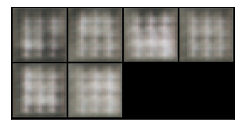

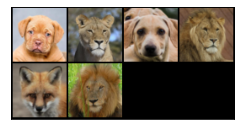

Epoch : [2 / 50] --> Discriminator Loss : -21.9162 , Generator Loss : -941.3171


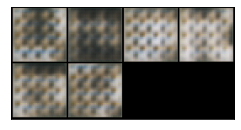

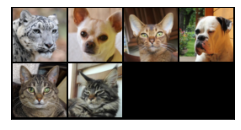

Epoch : [3 / 50] --> Discriminator Loss : -22.5765 , Generator Loss : -952.6755


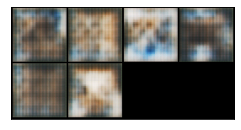

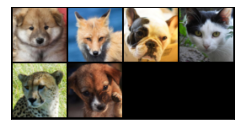

Epoch : [4 / 50] --> Discriminator Loss : 5.9517 , Generator Loss : -958.1420


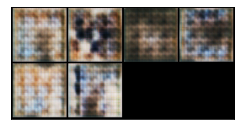

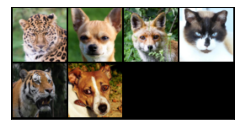

Epoch : [5 / 50] --> Discriminator Loss : -12.1395 , Generator Loss : -956.0409


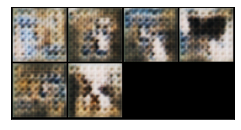

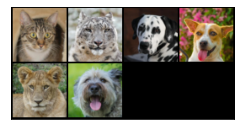

Epoch : [6 / 50] --> Discriminator Loss : -10.2423 , Generator Loss : -917.0732


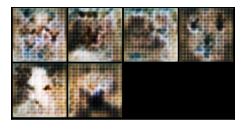

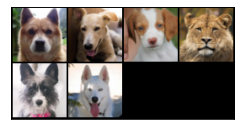

Epoch : [7 / 50] --> Discriminator Loss : -8.6422 , Generator Loss : -896.9088


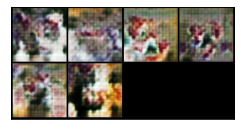

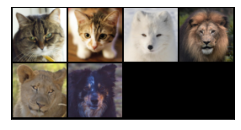

Epoch : [8 / 50] --> Discriminator Loss : -39.4739 , Generator Loss : -824.0468


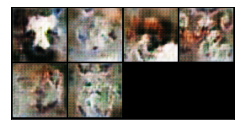

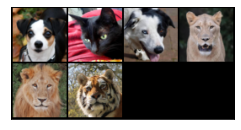

Epoch : [9 / 50] --> Discriminator Loss : -2.3920 , Generator Loss : -789.6415


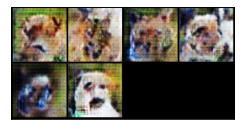

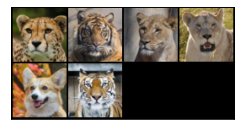

Epoch : [10 / 50] --> Discriminator Loss : -15.4968 , Generator Loss : -758.7755


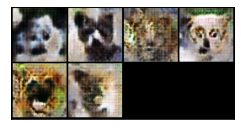

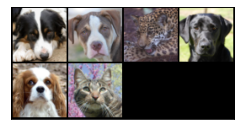

Epoch : [11 / 50] --> Discriminator Loss : 16.3403 , Generator Loss : -648.3600


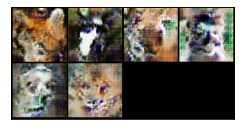

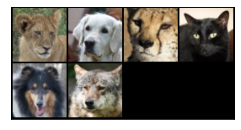

Epoch : [12 / 50] --> Discriminator Loss : -4.7855 , Generator Loss : -606.5303


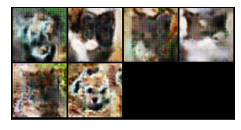

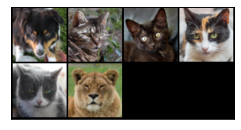

Epoch : [13 / 50] --> Discriminator Loss : -1.3221 , Generator Loss : -610.2740


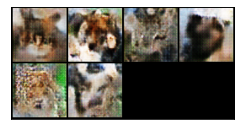

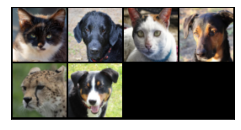

Epoch : [14 / 50] --> Discriminator Loss : 35.3354 , Generator Loss : -563.5818


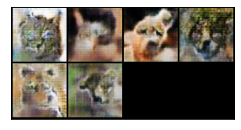

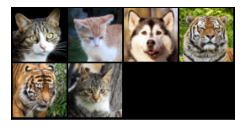

Epoch : [15 / 50] --> Discriminator Loss : -1.9890 , Generator Loss : -604.3776


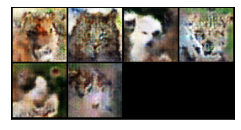

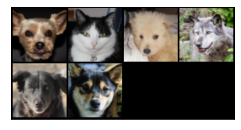

Epoch : [16 / 50] --> Discriminator Loss : 56.2233 , Generator Loss : -569.5366


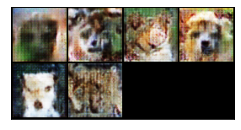

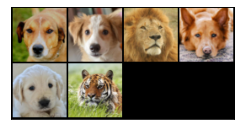

Epoch : [17 / 50] --> Discriminator Loss : -1.6140 , Generator Loss : -526.5005


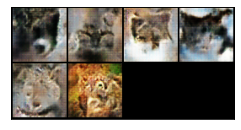

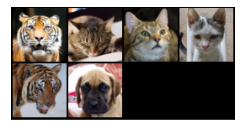

Epoch : [18 / 50] --> Discriminator Loss : -8.7353 , Generator Loss : -545.9999


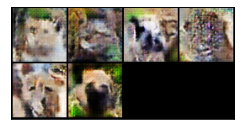

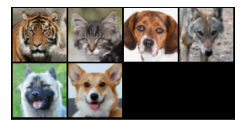

Epoch : [19 / 50] --> Discriminator Loss : -5.4718 , Generator Loss : -488.1105


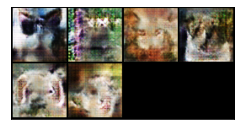

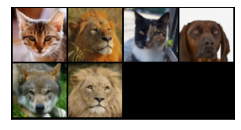

Epoch : [20 / 50] --> Discriminator Loss : 328.1512 , Generator Loss : -414.4167


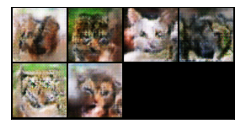

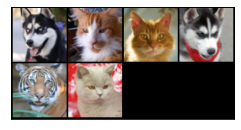

Epoch : [21 / 50] --> Discriminator Loss : 11.9829 , Generator Loss : -386.0211


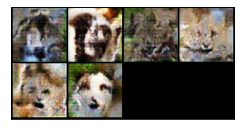

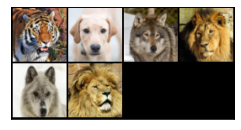

Epoch : [22 / 50] --> Discriminator Loss : 5.2420 , Generator Loss : -411.5372


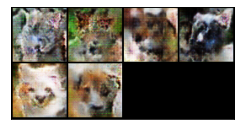

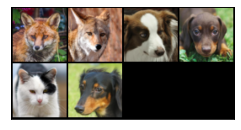

Epoch : [23 / 50] --> Discriminator Loss : 4.2234 , Generator Loss : -364.1462


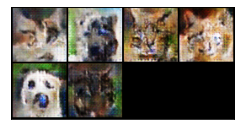

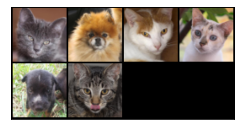

Epoch : [24 / 50] --> Discriminator Loss : -5.8982 , Generator Loss : -318.8286


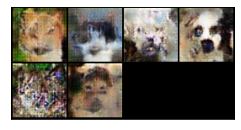

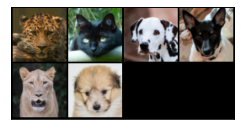

Epoch : [25 / 50] --> Discriminator Loss : -11.2266 , Generator Loss : -314.3656


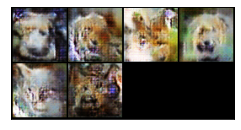

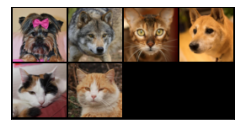

Epoch : [26 / 50] --> Discriminator Loss : 0.3293 , Generator Loss : -345.7405


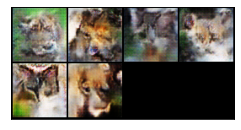

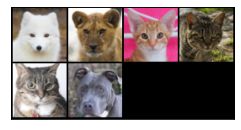

Epoch : [27 / 50] --> Discriminator Loss : -21.9097 , Generator Loss : -350.8229


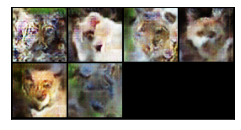

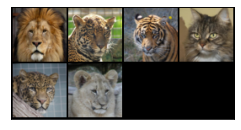

Epoch : [28 / 50] --> Discriminator Loss : 7.5824 , Generator Loss : -350.4701


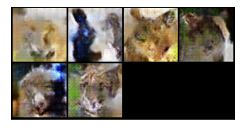

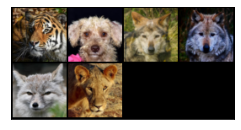

Epoch : [29 / 50] --> Discriminator Loss : 3.7551 , Generator Loss : -319.6927


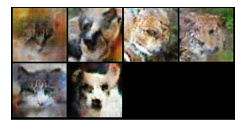

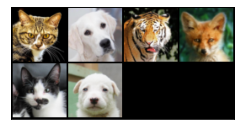

Epoch : [30 / 50] --> Discriminator Loss : -11.9338 , Generator Loss : -350.6553


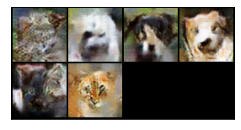

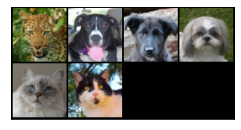

Epoch : [31 / 50] --> Discriminator Loss : 15.2716 , Generator Loss : -359.0432


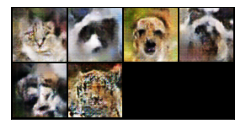

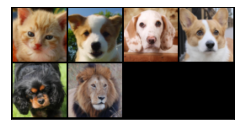

Epoch : [32 / 50] --> Discriminator Loss : 2.4586 , Generator Loss : -386.8286


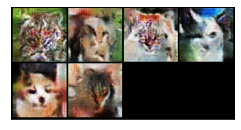

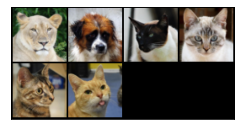

Epoch : [33 / 50] --> Discriminator Loss : -41.7048 , Generator Loss : -446.7597


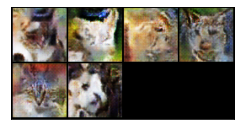

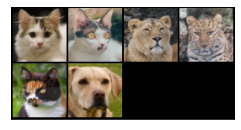

Epoch : [34 / 50] --> Discriminator Loss : 82.5227 , Generator Loss : -418.3381


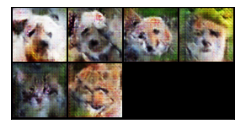

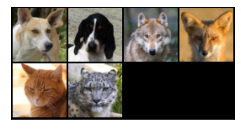

Epoch : [35 / 50] --> Discriminator Loss : -101.2654 , Generator Loss : -23.6135


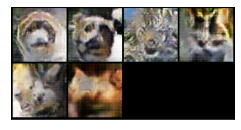

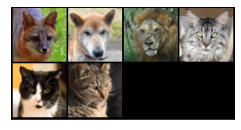

Epoch : [36 / 50] --> Discriminator Loss : -35.1224 , Generator Loss : -510.2020


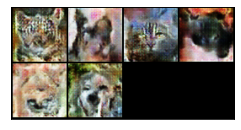

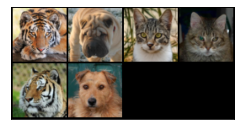

Epoch : [37 / 50] --> Discriminator Loss : -21.4975 , Generator Loss : -313.1910


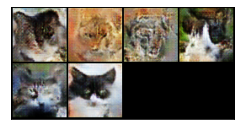

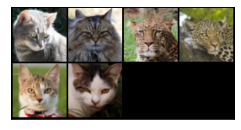

Epoch : [38 / 50] --> Discriminator Loss : -19.9196 , Generator Loss : -343.8895


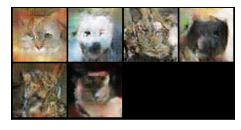

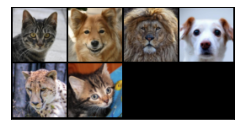

Epoch : [39 / 50] --> Discriminator Loss : -357.8170 , Generator Loss : -605.4496


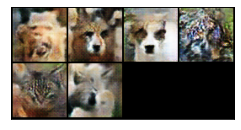

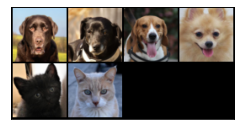

Epoch : [40 / 50] --> Discriminator Loss : -22.4621 , Generator Loss : -363.9350


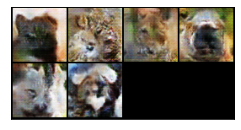

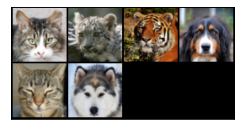

Epoch : [41 / 50] --> Discriminator Loss : -17.4157 , Generator Loss : -303.2621


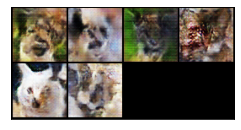

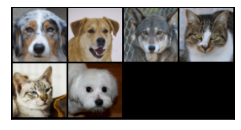

Epoch : [42 / 50] --> Discriminator Loss : -4.7183 , Generator Loss : -308.3823


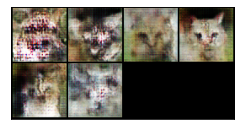

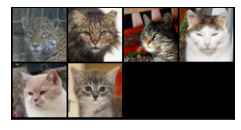

Epoch : [43 / 50] --> Discriminator Loss : -1.5836 , Generator Loss : -288.1934


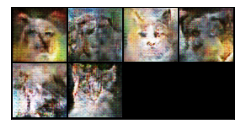

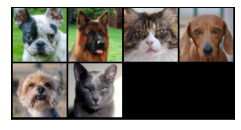

Epoch : [44 / 50] --> Discriminator Loss : 16.3575 , Generator Loss : -302.6753


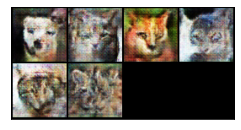

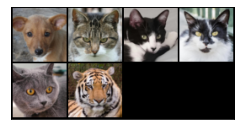

Epoch : [45 / 50] --> Discriminator Loss : -3.4778 , Generator Loss : -283.9644


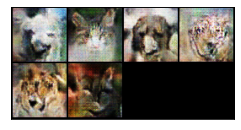

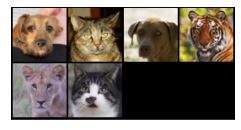

Epoch : [46 / 50] --> Discriminator Loss : -9.5465 , Generator Loss : -324.4555


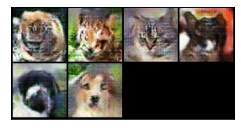

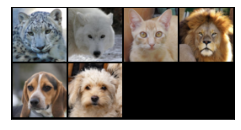

Epoch : [47 / 50] --> Discriminator Loss : -0.8231 , Generator Loss : -246.8248


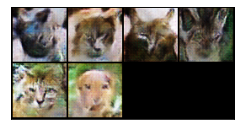

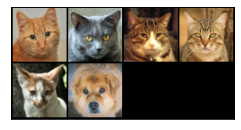

Epoch : [48 / 50] --> Discriminator Loss : 55.4486 , Generator Loss : -181.9810


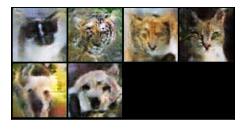

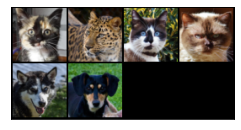

Epoch : [49 / 50] --> Discriminator Loss : 29.9787 , Generator Loss : -428.9826


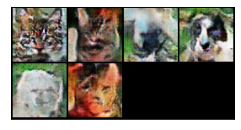

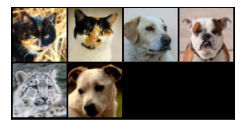

Epoch : [50 / 50] --> Discriminator Loss : -10.6356 , Generator Loss : -408.5901


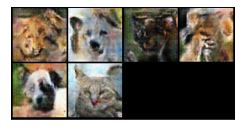

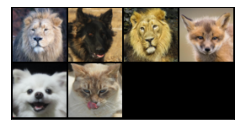

In [27]:
## Training the model ##

num_epochs = 50
reg_lambda = 10

## To train critic more than the generator ##
disc_repeat = 2

for epoch in range(num_epochs):
    
    for img , label in animal_dl:
        
        batch_size = len(img)
        one_hot_labels = make_one_hot(label , num_classes = 3).to(device) 
        
        image_one_hot = repeat_val(one_hot_labels , img.shape[2]).to(device)
        
        for _ in range(disc_repeat):
            
            noise = gen_noise(batch_size , noise_dim = 100).to(device)
            
            gen_inp = concat(noise , one_hot_labels)
            
            fake_img = gen(gen_inp).detach()
            
            gen_img = concat(fake_img , image_one_hot)
            
            disc_fake_pred = disc(gen_img)
            
            disc_img = concat(img , image_one_hot)
            
            disc_real_pred = disc(disc_img)
            
            epsilon = torch.randn(batch_size , 1 , 1 , 1 , requires_grad = True).to(device)
            
            grad = get_grad(disc , gen_img , disc_img , epsilon)
            
            gp = grad_penalty(grad)
            
            disc_opt.zero_grad()
            
            disc_loss = discriminator_loss(disc_real_pred , disc_fake_pred , gp , reg_lambda)
            
            disc_loss.backward(retain_graph = True)
            
            disc_opt.step()
            
        gen_opt.zero_grad()
        
        noise = gen_noise(batch_size , noise_dim = 100).to(device)
        
        gen_inp = concat(noise , one_hot_labels)
        
        fake_img = gen(gen_inp)
            
        gen_img = concat(fake_img , image_one_hot)
            
        disc_fake_pred = disc(gen_img)
        
        gen_loss = generator_loss(disc_fake_pred)
        
        gen_loss.backward()
        
        gen_opt.step()
        
    print('Epoch : [{} / {}] --> Discriminator Loss : {:.4f} , Generator Loss : {:.4f}'.format(epoch + 1 , num_epochs , disc_loss.item() , gen_loss.item()))
    
    rand_noise = gen_noise(batch_size , noise_dim = 100).to(device)
    
    gen_inp = concat(rand_noise , one_hot_labels)
    
    fake_img = gen(gen_inp).detach()
    
    show_img(fake_img)
    
    show_img(img)

In [28]:
## Saving the generator and discriminator models ##

torch.save(gen , 'generator.pth')
torch.save(disc , 'discriminator.pth')